In [12]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import numpy as np
import torch as th

from src.data.comp_2d import GmmRadial

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

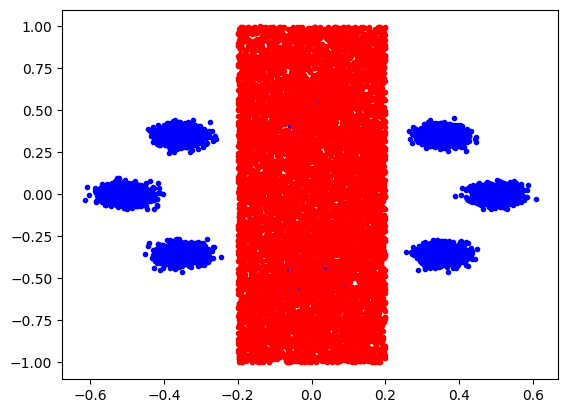

In [13]:
import numpy as np
import torch as th
from src.data.comp_2d import GmmRadial, Bar
import matplotlib.pyplot as plt

num_samples = 10_000
gmm_data = GmmRadial(8)
gmm_samples, _ = gmm_data.sample(num_samples)
bar_data = Bar()
bar_samples, _ = bar_data.sample(num_samples)

plt.plot(gmm_samples[:, 0], gmm_samples[:, 1], 'b.')
plt.plot(bar_samples[:, 0], bar_samples[:, 1], 'r.')

# Product composition

Given two unconditional score-parameterised diffusion models:
$$
\epsilon_\theta^{GMM}(x_t, t),\quad \epsilon_\theta^{Bar}(x_t, t)
$$
Trained separately on the two datasets above respectively.
Below are samples drawn from the reverse process of each model.

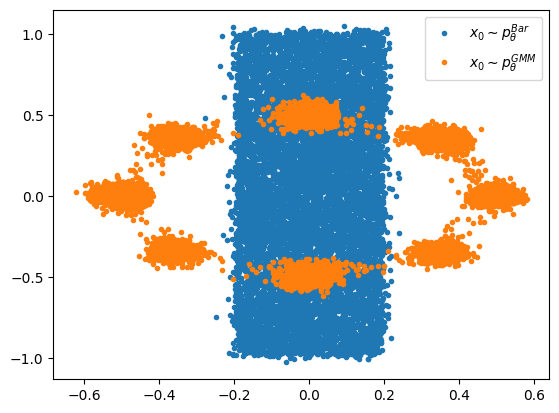

In [14]:
from pathlib import Path
import matplotlib.pyplot as plt
bar_xs = th.load(Path.cwd().parent / "results/comp_2d/bar_samples.th")
gmm_xs = th.load(Path.cwd().parent / "results/comp_2d/gmm_samples.th")

plt.plot(bar_xs[:, 0], bar_xs[:, 1], '.', label="$x_0 \sim p_\\theta^{Bar}$")
plt.plot(gmm_xs[:, 0], gmm_xs[:, 1], '.', label="$x_0 \sim p_\\theta^{GMM}$")
plt.legend()

## Sampling from product composition
To sample from the composed model, we compose a score
$$
\nabla_{x_t} \log p_\theta^{prod} = - \frac{1}{\sigma_t} \left( \epsilon_\theta^{GMM}(x_t, t) + \epsilon_\theta^{Bar}(x_t, t) \right).
$$

Text(0.5, 1.0, 'HMC')

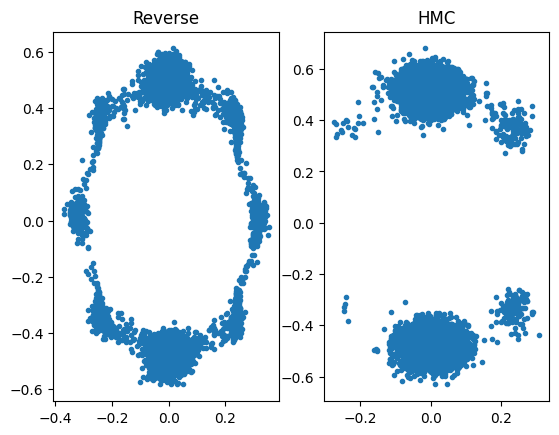

In [15]:
from pathlib import Path
import matplotlib.pyplot as plt
reverse_samples = th.load(Path.cwd().parent / "results/comp_2d/prod_samples_reverse.th")
hmc_samples = th.load(Path.cwd().parent / "results/comp_2d/prod_samples_hmc_without_rev.th")
_, (ax_rev, ax_hmc) = plt.subplots(1, 2)
ax_rev.plot(reverse_samples[:, 0], reverse_samples[:, 1], '.')
ax_rev.set_title("Reverse")
ax_hmc.plot(hmc_samples[:, 0], hmc_samples[:, 1], '.')
ax_hmc.set_title("HMC")

# Guidance

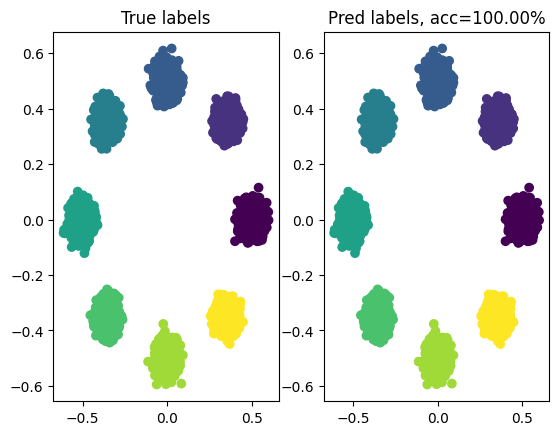

In [16]:
import numpy as np
import torch as th
from src.data.comp_2d import GmmRadial, Bar
import matplotlib.pyplot as plt
from src.model.comp_2d.classifier import Classifier, load_classifier
from src.utils.metrics import accuracy, hard_label_from_logit

num_samples = 10_000
T = 100
gmm_data = GmmRadial(8)
gmm_samples, labels = gmm_data.sample(num_samples)

_, [ax_true, ax_pred] = plt.subplots(1, 2)
ax_true.scatter(gmm_samples[:, 0], gmm_samples[:, 1], c=labels)
ax_true.set_title("True labels")

params = Path.cwd().parent / "models/comp_2d/class_t_gmm.pt"
class_ = load_classifier(params, gmm_data.n_comp, "cpu")
t = th.ones((num_samples,)).long()
logits = class_(gmm_samples, t)
pred_y = hard_label_from_logit(logits)
acc = accuracy(pred_y, labels)

ax_pred.scatter(gmm_samples[:, 0], gmm_samples[:, 1], c=pred_y)
ax_pred.set_title(f"Pred labels, acc={acc.item()*100:.2f}%");

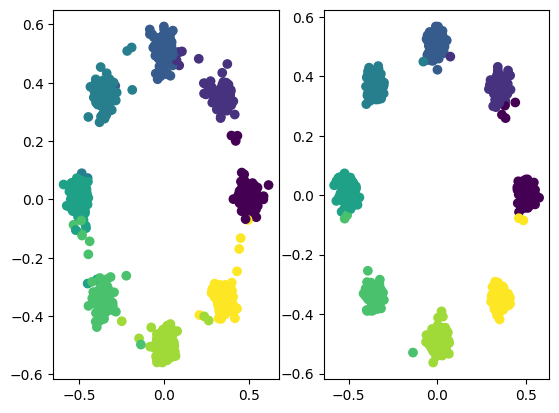

In [17]:
classes = th.load(Path.cwd().parent / "results/comp_2d/guid_classes_gmm.th")

guid_samples = th.load(Path.cwd().parent / "results/comp_2d/guid_samples_gmm.th")
hmc_guid_samples = th.load(Path.cwd().parent / "results/comp_2d/hmc_guid_samples_gmm.th")
classes = th.load(Path.cwd().parent / "results/comp_2d/guid_classes_gmm.th")
_, [ax_guid, ax_hmc] = plt.subplots(1, 2)
ax_guid.scatter(guid_samples[:, 0], guid_samples[:, 1], c=classes)
ax_hmc.scatter(hmc_guid_samples[:, 0], hmc_guid_samples[:, 1], c=classes)
